<a href="https://colab.research.google.com/github/S-loaiza-UAO/Machine-learning-UAO/blob/main/Proyecto_final_aprendizaje_automatico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final: aprendizaje Automático

**Objetivo:** Implementación de un modelo de aprendizaje supervisado para la predicción y clasificación en dos estados de una condición operativa que se presenta en el proceso de vapor de un ingenio azucarero colombiano y que afecta la eficiencia energética.

**Data Set:** El conjunto de datos es obtenido a través de los diferentes sensores y medidores en campo, los cuales son almacenados en el sistema de control. Desde allí se obtienen algunas variables representativas con las cuales se puede entrenar el modelo. Cada fila corresponde a una condición aleatoria en una fecha aleatoria, la cual ha sido analizada para determinar si aplica o no. De alli se compone un archivo de 150 filas o registros x 9 columnas o atributos "[150,9]".

**Variables:**

1. Rata de molienda (m3/h): indica la fase inicio del proceso de molienda donde se determinan los flujos iniciales de operación.
2. Flujo de jugo claro al 1er efecto de evaporación (m3/h): Postierior al proceso de purificacion del jugo de molienda y con la recepcion de retornos se inicia bombeo a evaporación.
3. Temperatura de jugo claro al 1er efecto después del calentamiento (°C): Parte de la eficiencia del proceso de evaporación esta determinada por la temperatura del jugo claro, ya que menores temperaturas indicaran aumento en los flujos de vapor para obtener temperaturas a presión de saturación.
4. Presión de vapor en calandria (psig): Esta variable indica la presion manometrica de vapor de escape saturado que ingresa al intercambiador.
5. Apertura de válvula de control de vapor (%).
6. Flujo de vapor de escape a evaporación (Klb/h): Este valor es un estimativo del flujo que ingresa a fabrica de azucar y se por la diferencia del vapor total generado - el vapor destinado a la condensación.
7. Flujo total de vapor vivo generado (Klb/h)
8. Flujo de vapor a condensación (Klb/h).
9. Exceso de vapor o la variable objetivo y esta indicada en valor BINARIO donde: 0 == NO y 1 == SI.






# Importación de Librerías


In [44]:
!pip install pycaret

In [1]:
# Importación de librerías
import pandas as pd
import requests
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from matplotlib.patheffects import withStroke
from scipy import stats
import numpy as np
import itertools
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, accuracy_score, precision_score, recall_score
import pathlib as pl
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment

# Fase 1: Importe de Data Set y tratamiento inicial de la información.

In [2]:
!git clone https://github.com/S-loaiza-UAO/Machine-learning-UAO
%cd Machine-learning-UAO

fatal: destination path 'Machine-learning-UAO' already exists and is not an empty directory.
/content/Machine-learning-UAO


In [3]:
df = pd.read_csv("DATA_SET_EVMC_V2.csv",sep=";", index_col=False, encoding='latin1')                                   # Lectura del archivo CSV cargado anteriormente
df = df.replace(',', '.', regex=True)                                                                         # Para evitar problemas en la lectura de los numeros decimales que vienen separados con ",", se hace un reemplazo a puntos"."
df.columns = ["RATA DE MOLIENDA (m3/h)", "FLUJO DE JUGO CLARO (m3/h)", "TEMPERATURA DE JUGO CLARO (°C)",
             "PRESION PSIG CALANDRIA 1","% APERTURA VALVULA VAPOR CALANDRIA 1","FLUJO VAPOR EVAPORACION",
              "FLUJO VAPOR VIVO TOTAL","FLUJO VAPOR CONDENSACION","EXCESO VAPOR"]
df.head()

,RATA DE MOLIENDA (m3/h),FLUJO DE JUGO CLARO (m3/h),TEMPERATURA DE JUGO CLARO (°C),PRESION PSIG CALANDRIA 1,% APERTURA VALVULA VAPOR CALANDRIA 1,FLUJO VAPOR EVAPORACION,FLUJO VAPOR VIVO TOTAL,FLUJO VAPOR CONDENSACION,EXCESO VAPOR
0,220,218,108.0,16.54,94.47,231.74,320.0,88,0.
1,228,240,106.0,17.17,67.76,278.41,325.0,47,1.
2,184,267,107.0,18.5,51.85,217.76,310.0,92,1.
3,202,227,105.0,18.51,67.29,217.76,310.0,92,0.
4,193,239,109.0,18.52,67.4,235.52,294.0,58,1.


In [4]:
print("Tamaño del conjunto de datos:",df.shape)# Imprimir parte de los datos den data_frame

Tamaño del conjunto de datos: (150, 9)


In [5]:
atributos= df.columns
print(atributos)

Index(['RATA DE MOLIENDA (m3/h)', 'FLUJO DE JUGO CLARO (m3/h)',
       'TEMPERATURA DE JUGO CLARO (°C)', 'PRESION PSIG CALANDRIA 1',
       '% APERTURA VALVULA VAPOR CALANDRIA 1', 'FLUJO VAPOR EVAPORACION',
       'FLUJO VAPOR VIVO TOTAL', 'FLUJO VAPOR CONDENSACION', 'EXCESO VAPOR'],
      dtype='object')


In [6]:
# Información general del DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RATA DE MOLIENDA (m3/h)               148 non-null    object 
 1   FLUJO DE JUGO CLARO (m3/h)            149 non-null    object 
 2   TEMPERATURA DE JUGO CLARO (°C)        146 non-null    float64
 3   PRESION PSIG CALANDRIA 1              149 non-null    object 
 4   % APERTURA VALVULA VAPOR CALANDRIA 1  149 non-null    object 
 5   FLUJO VAPOR EVAPORACION               148 non-null    object 
 6   FLUJO VAPOR VIVO TOTAL                148 non-null    float64
 7   FLUJO VAPOR CONDENSACION              149 non-null    object 
 8   EXCESO VAPOR                          149 non-null    object 
dtypes: float64(2), object(7)
memory usage: 10.7+ KB
None


Tal y como se observa anteriormente algunos de los atributos que deberian ser numéricos, aparecen como categóricos. Por lo tanto se realizara una conversion de los atributos a float64.
Esto puede ocurrir por la presencia de datos mal escritos o tal vez por la forma como estan escritos algunos de los números decimales con "punto" y no con "coma".

Tambien se observa que hay variables que presentan diferencia en los valores de los registros, se realizara un barrido de los registros para identificar que datos se presentan.

In [7]:
variable_categorica= df.select_dtypes(include=['object']).columns[0:]
print(variable_categorica)

Index(['RATA DE MOLIENDA (m3/h)', 'FLUJO DE JUGO CLARO (m3/h)',
       'PRESION PSIG CALANDRIA 1', '% APERTURA VALVULA VAPOR CALANDRIA 1',
       'FLUJO VAPOR EVAPORACION', 'FLUJO VAPOR CONDENSACION', 'EXCESO VAPOR'],
      dtype='object')


En el siguiente aparte seran revisados los atributos que presentan registros faltantes o en blanco.

In [8]:
# Contar valores nulos por columna
df.isnull().sum()

RATA DE MOLIENDA (m3/h)                 2
FLUJO DE JUGO CLARO (m3/h)              1
TEMPERATURA DE JUGO CLARO (°C)          4
PRESION PSIG CALANDRIA 1                1
% APERTURA VALVULA VAPOR CALANDRIA 1    1
FLUJO VAPOR EVAPORACION                 2
FLUJO VAPOR VIVO TOTAL                  2
FLUJO VAPOR CONDENSACION                1
EXCESO VAPOR                            1
dtype: int64

A continuacion seran evaluados los registros que no son nulos pero que pueden estar como valores no numericos e identificar que tipo de registro contiene y lograr la conversion correctamente.

In [9]:
def identificar_no_numericos(df1, atributos):
  """
  Esta función identifica los datos no numéricos en una serie de atributos de un DataFrame.

  Parámetros:
    df: El DataFrame que contiene los datos.
    atributos: Una lista con los nombres de los atributos que se desean analizar.

  Retorno:
    Un diccionario con los nombres de los atributos como claves y las listas de valores no numéricos como valores.
  """
  no_numericos = {}
  for atributo in atributos:
    no_numericos[atributo] = []
    for i, valor in enumerate(df[atributo]):
      try:
        # Convertimos el valor a un número flotante
        float(valor)
      except ValueError:
        # Si no se puede convertir, es un dato no numérico
        no_numericos[atributo].append(valor)
  return no_numericos

df1=df.copy()
#atributos= ['RATA DE MOLIENDA (m3/h)', 'TEMPERATURA DE JUGO CLARO (°C)','FLUJO VAPOR EVAPORACION', 'FLUJO VAPOR VIVO TOTAL', 'EXCESO VAPOR']
no_numericos = identificar_no_numericos(df, atributos)
print(no_numericos)

{'RATA DE MOLIENDA (m3/h)': ['199;284;108;16.62;99.64'], 'FLUJO DE JUGO CLARO (m3/h)': [], 'TEMPERATURA DE JUGO CLARO (°C)': [], 'PRESION PSIG CALANDRIA 1': [], '% APERTURA VALVULA VAPOR CALANDRIA 1': ['1..'], 'FLUJO VAPOR EVAPORACION': [], 'FLUJO VAPOR VIVO TOTAL': [], 'FLUJO VAPOR CONDENSACION': [], 'EXCESO VAPOR': ['si.', 'no.', '0..', 'SI.', 'no aplica.', '0..', '1..', 'no.', '0..', '0..', 'si.', 'SI ES', 'NO']}


De acuerdo con el resultado obtenido, la variable:
* Rata molienda: presenta 2 valores atipicos separados por "punto" y no por "coma".
* Temperatura de jugo claro tiene 4 registros en blanco
* Presión de calandria, apertura de valvula de control y flujo a condensacion tienen 1 registro en blanco cada uno.
* Flujo vapor evaporacion y flujo vapor vivo total contienen cada atributo 2 registros en blanco.
* El atributo EXCESO VAPOR presenta mas variaciones en los datos, 1 dato en blanco y otros registros tales como: ['si.', 'no.', '0..', 'SI.', 'no aplica.', '0..', '1..', 'no.', '0..', '0..', 'si.', 'SI ES', 'NO']

Se realizara un primer barrido eliminando los datos nulos de las variables. Asi podremos evaluar la cantidad de registros que finalmente obtendremos.

In [10]:
# Eliminar filas que contienen valores nulos
df = df[~df.isnull().any(axis=1)]

# Eliminar filas que contienen valores blancos
df = df[~df.eq('').any(axis=1)]

# Contar valores nulos por columna
df.isnull().sum()

RATA DE MOLIENDA (m3/h)                 0
FLUJO DE JUGO CLARO (m3/h)              0
TEMPERATURA DE JUGO CLARO (°C)          0
PRESION PSIG CALANDRIA 1                0
% APERTURA VALVULA VAPOR CALANDRIA 1    0
FLUJO VAPOR EVAPORACION                 0
FLUJO VAPOR VIVO TOTAL                  0
FLUJO VAPOR CONDENSACION                0
EXCESO VAPOR                            0
dtype: int64

Realizamos la conversion de los atributos dtype: object a float64 y revisamos nuevamente el conteo de registros disponibles.
En este caso exeptuaremos la variable EXCESO VAPOR, donde se evidencia un total de 139 registros de 149 inicialmente, fueron eliminados 10 registros nulos.

In [11]:
df['RATA DE MOLIENDA (m3/h)'] = df['RATA DE MOLIENDA (m3/h)'].astype('float64')
df['FLUJO DE JUGO CLARO (m3/h)'] = df['FLUJO DE JUGO CLARO (m3/h)'].astype('float64')
df['PRESION PSIG CALANDRIA 1'] = df['PRESION PSIG CALANDRIA 1'].astype('float64')
df['% APERTURA VALVULA VAPOR CALANDRIA 1'] = df['% APERTURA VALVULA VAPOR CALANDRIA 1'].astype('float64')
df['FLUJO VAPOR EVAPORACION'] = df['FLUJO VAPOR EVAPORACION'].astype('float64')
df['FLUJO VAPOR CONDENSACION'] = df['FLUJO VAPOR CONDENSACION'].astype('float64')

# Información general del DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 148
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RATA DE MOLIENDA (m3/h)               139 non-null    float64
 1   FLUJO DE JUGO CLARO (m3/h)            139 non-null    float64
 2   TEMPERATURA DE JUGO CLARO (°C)        139 non-null    float64
 3   PRESION PSIG CALANDRIA 1              139 non-null    float64
 4   % APERTURA VALVULA VAPOR CALANDRIA 1  139 non-null    float64
 5   FLUJO VAPOR EVAPORACION               139 non-null    float64
 6   FLUJO VAPOR VIVO TOTAL                139 non-null    float64
 7   FLUJO VAPOR CONDENSACION              139 non-null    float64
 8   EXCESO VAPOR                          139 non-null    object 
dtypes: float64(8), object(1)
memory usage: 10.9+ KB
None


Con el analisis de registros no numericos, podemos hacer un reemplazo de los datos para asi evitar perder mas registros en el data set.

In [12]:
# Reemplazar valores string por float
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('si.', 1)
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('SI.', 1)
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('1..', 1)
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('SI ES', 1)
# Reemplazar valores string por float
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('no.', 0)
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('0..', 0)
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('no aplica.', 0)
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].replace('NO', 0)
# Reemplazar valores string por float usando expresiones regulares
#df['Columna'] = df['Columna'].str.replace('[a-z]', 1.0)


In [13]:
df['EXCESO VAPOR'] = df['EXCESO VAPOR'].astype('float64')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 0 to 148
Data columns (total 9 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RATA DE MOLIENDA (m3/h)               139 non-null    float64
 1   FLUJO DE JUGO CLARO (m3/h)            139 non-null    float64
 2   TEMPERATURA DE JUGO CLARO (°C)        139 non-null    float64
 3   PRESION PSIG CALANDRIA 1              139 non-null    float64
 4   % APERTURA VALVULA VAPOR CALANDRIA 1  139 non-null    float64
 5   FLUJO VAPOR EVAPORACION               139 non-null    float64
 6   FLUJO VAPOR VIVO TOTAL                139 non-null    float64
 7   FLUJO VAPOR CONDENSACION              139 non-null    float64
 8   EXCESO VAPOR                          139 non-null    float64
dtypes: float64(9)
memory usage: 10.9 KB
None


In [14]:
# Estadísticas descriptivas
print(df.describe())

       RATA DE MOLIENDA (m3/h)  FLUJO DE JUGO CLARO (m3/h)  \
count               139.000000                  139.000000   
mean                206.625899                  249.625899   
std                  15.434891                   24.605370   
min                 180.000000                  181.000000   
25%                 193.000000                  233.000000   
50%                 207.000000                  249.000000   
75%                 220.500000                  269.500000   
max                 230.000000                  290.000000   

       TEMPERATURA DE JUGO CLARO (°C)  PRESION PSIG CALANDRIA 1  \
count                      139.000000                139.000000   
mean                       107.776978                 18.303237   
std                          3.778358                  1.199748   
min                         90.000000                 13.910000   
25%                        106.000000                 17.635000   
50%                        108.000000  

# Resumen Etapa 1

* Clonar repositorio desde GitHub y cargar archivo .csv
* Revisión inicial del DataSet: tamaño, tipo de registros, atributos.
* Primera revision de valor nulos o faltantes.
* Revisión de valores no numericos - no nulos para reemplazar.
* Segunda revisión de tamaño de registros y transformacion de todos los atributos a dtype: float64
* Finalmente se obtienen variables estadisticas mas descriptivas del dataset con un tamaño final de 139 registros en 9 atributos.


In [15]:
df1=df.copy()

# Fase 2: EDA (Exploratory Data Analysis) + Visualización
* Gráfico de dispersion de las variables.
* Correlación de variables por metodo Pearson, Spearman y Kendall
* Distribución de datos mediante histogramas y teniendo como base la variable objetivo.
* Graficacion de informacion mediante cajas y bigotes general y teniendo como base la variable objetivo.



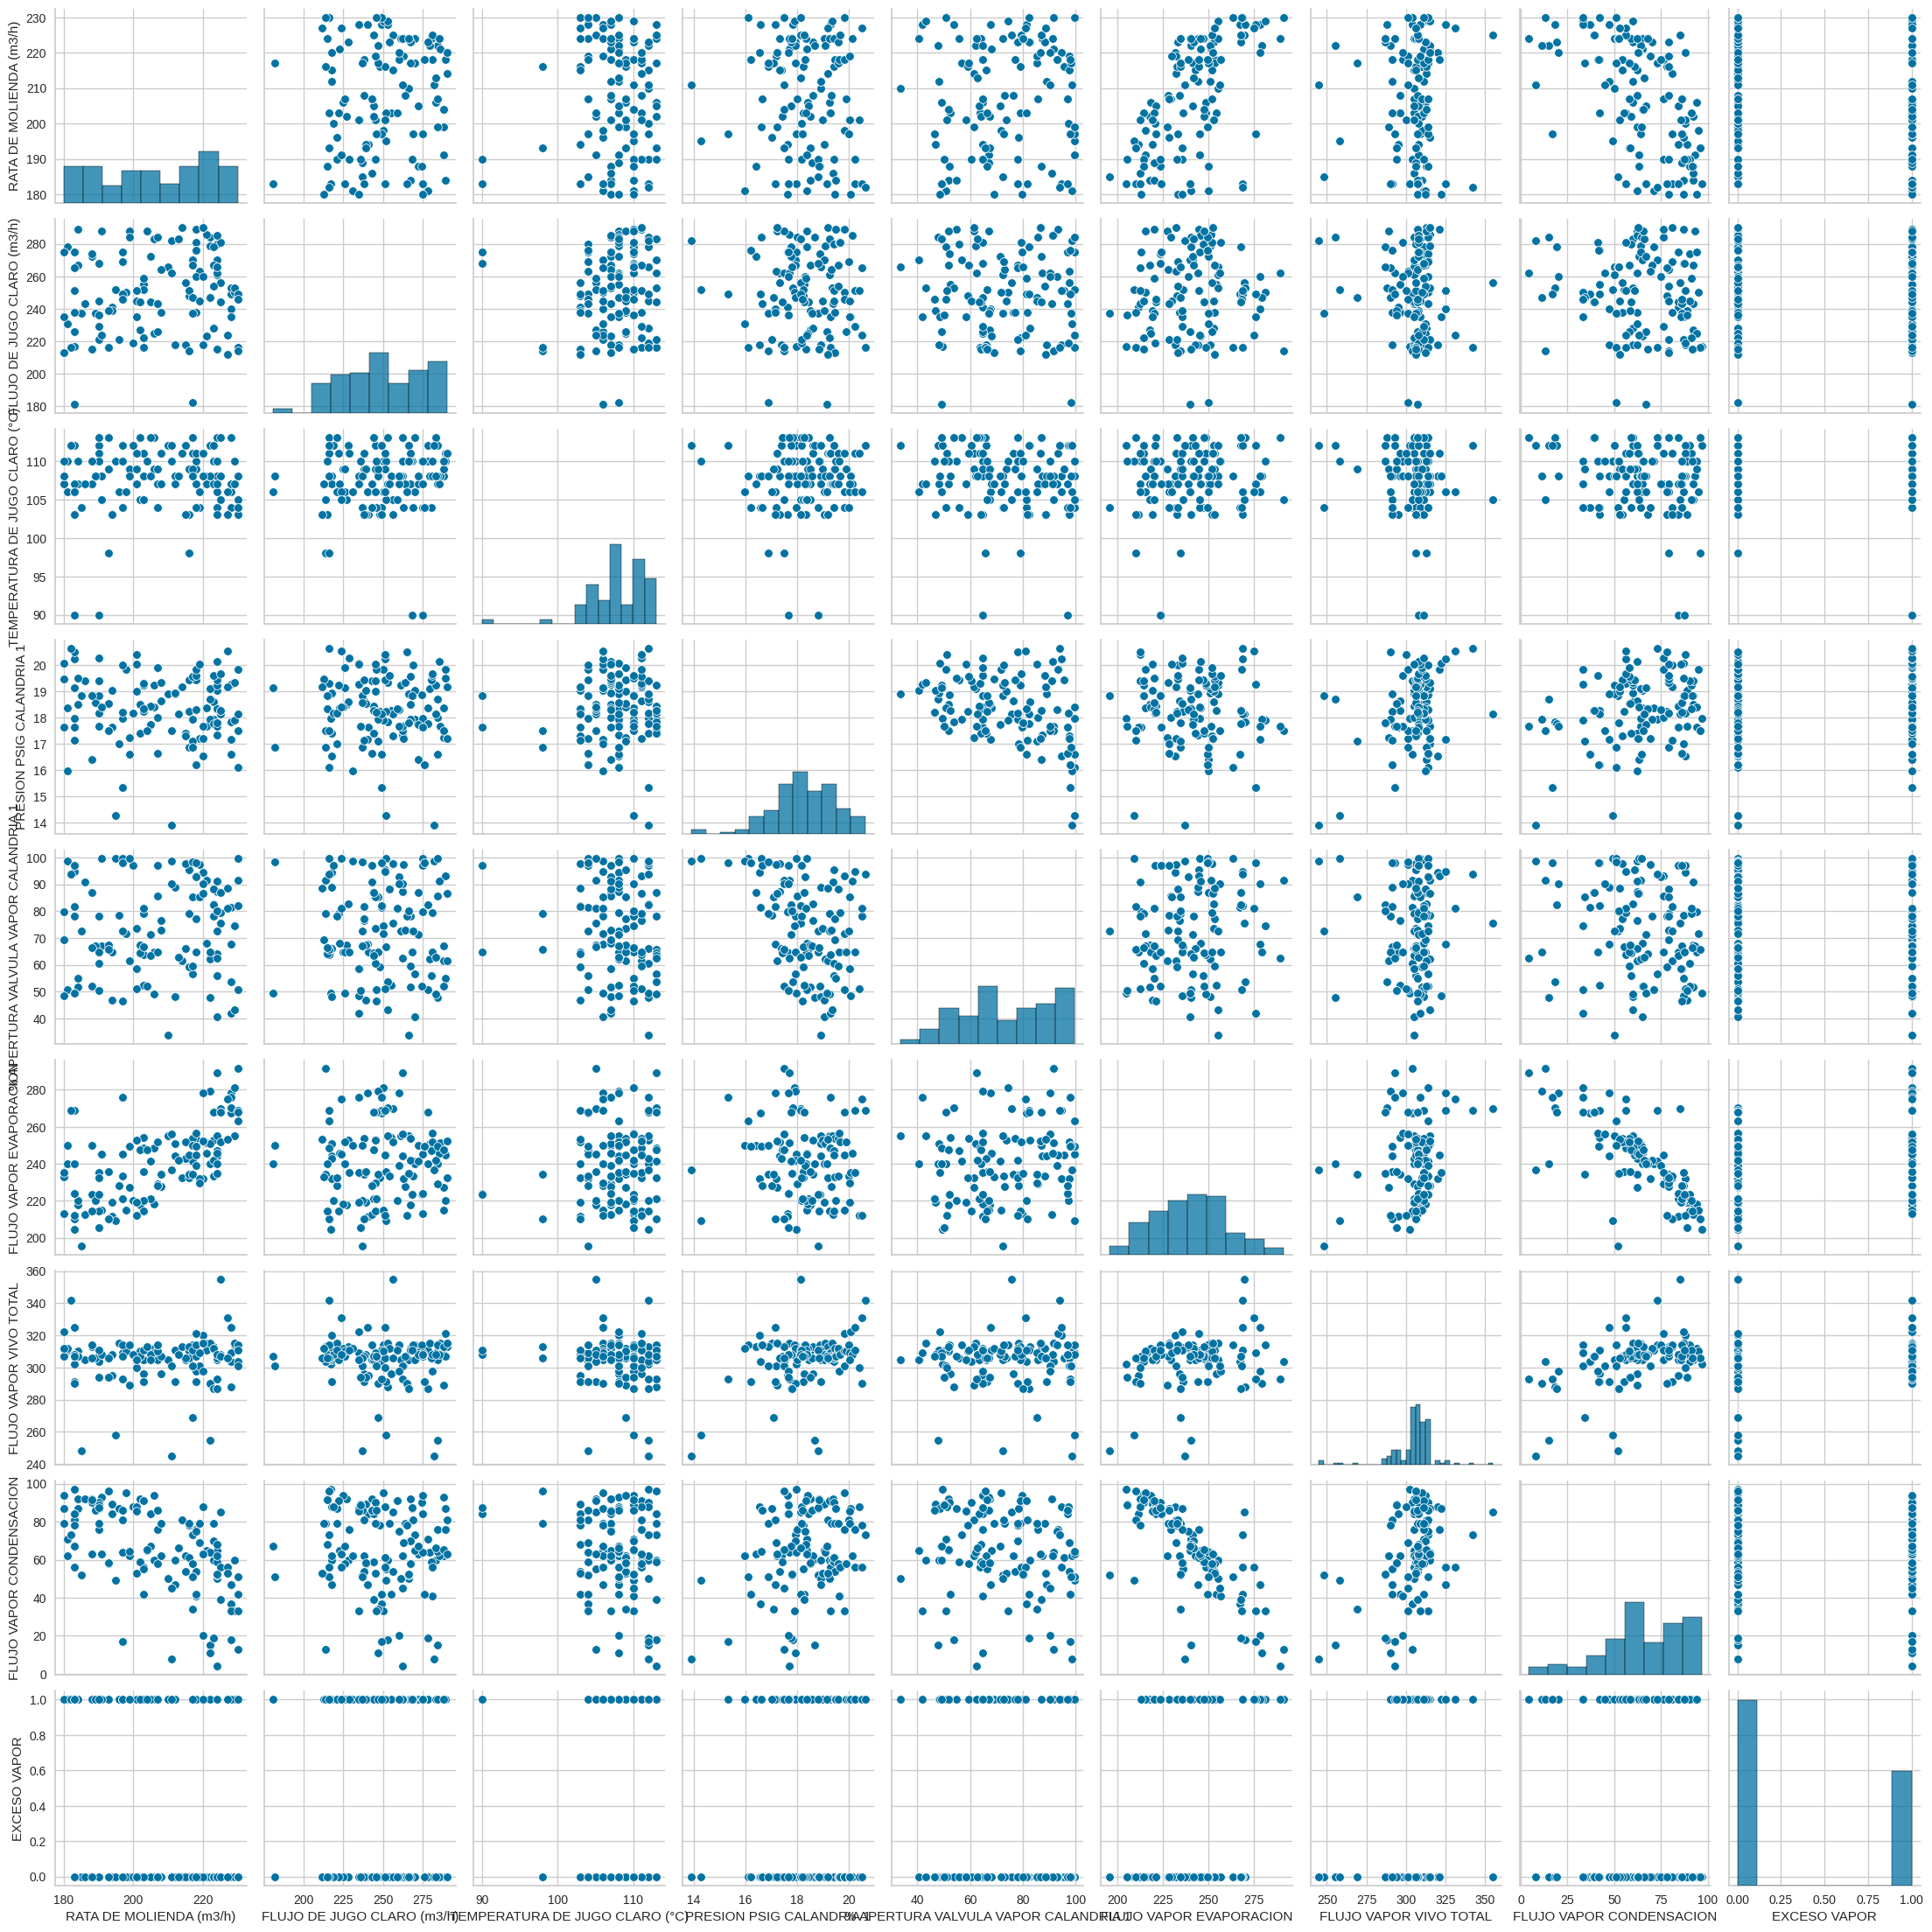

In [16]:
sns.pairplot(df1)

Text(0, 0.5, 'FLUJO VAPOR CONDENSACION')

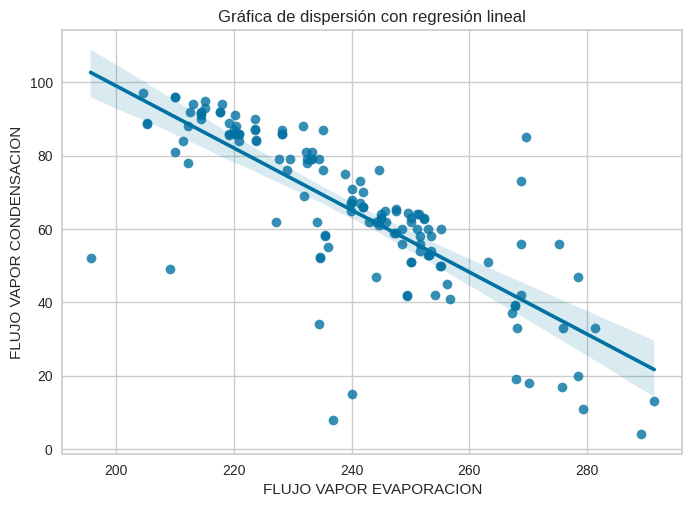

In [17]:
sns.regplot(x='FLUJO VAPOR EVAPORACION', y='FLUJO VAPOR CONDENSACION', data=df1)
plt.title('Gráfica de dispersión con regresión lineal')
plt.xlabel('FLUJO VAPOR EVAPORACION')
plt.ylabel('FLUJO VAPOR CONDENSACION')

Text(0, 0.5, 'FLUJO VAPOR EVAPORACIO')

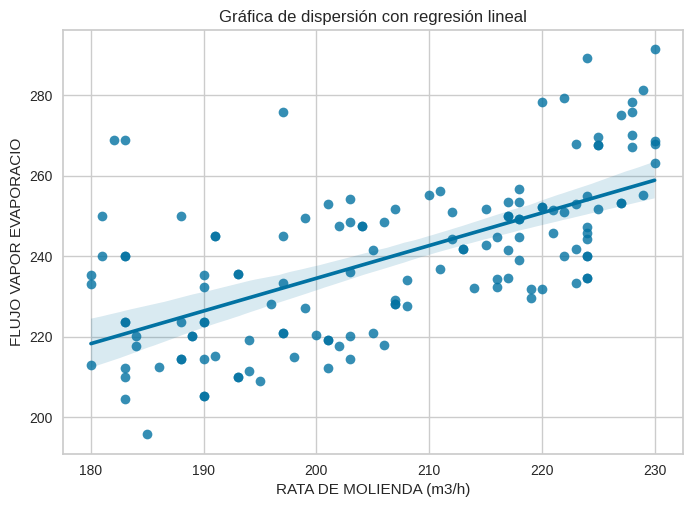

In [18]:
sns.regplot(x='RATA DE MOLIENDA (m3/h)', y='FLUJO VAPOR EVAPORACION', data=df1)
plt.title('Gráfica de dispersión con regresión lineal')
plt.xlabel('RATA DE MOLIENDA (m3/h)')
plt.ylabel('FLUJO VAPOR EVAPORACIO')

En esta primer etapa logramos evidenciar que:
* A mayor rata de molienda, el flujo de vapor hacia la evaporación aumenta proporcionalmente.
* Esto a su vez conlleva a que el flujo de vapor hacia la condensación de las turbinas disminuya. Por lo tanto es inversamente proporcional a la rata de molienda.

A continuacion evaluaremos otro tipo de correlaciones mediante los siguientes métodos:

1. Correlación de Pearson:

Mide la relación lineal entre dos variables cuantitativas.
Su valor varía entre -1 y 1:
-1: correlación negativa perfecta.
0: no hay correlación.
1: correlación positiva perfecta.
Es sensible a valores atípicos (outliers) que pueden distorsionar el resultado.
Se utiliza para predecir una variable a partir de la otra.
2. Correlación de Spearman:

Mide la relación monotónica (creciente o decreciente) entre dos variables cualitativas (ordinales) o cuantitativas.
Su valor varía entre -1 y 1, similar a la correlación de Pearson.
Es menos sensible a valores atípicos que la correlación de Pearson.
Se utiliza para comparar dos conjuntos de datos ordenados.
3. Correlación de Kendall:

Mide la concordancia entre dos variables cualitativas (ordinales) o cuantitativas.
Su valor varía entre -1 y 1, similar a la correlación de Pearson y Spearman.
Es menos sensible a valores atípicos que la correlación de Pearson.
Se utiliza para medir la asociación entre dos variables sin importar la forma de la relación.

In [19]:
def stars(p):
    """
    Returns a string of asterisks (*) based on the significance level (alpha value) of a statistical test.

    Args:
        p (float): the p-value of the statistical test

    Returns:
        A string of asterisks indicating the significance level, as follows:
        - five asterisks (*****): alpha value is 0.0001 or 0.01% with 99.99% confidence
        - four asterisks (****): alpha value is 0.001 or 0.1% with 99.9% confidence
        - three asterisks (***): alpha value is 0.01 or 1% with 99% confidence
        - two asterisks (**): alpha value is 0.05 or 5% with 95% confidence
        - one asterisk (*): alpha value is 0.1 or 10% with 90% confidence
        - empty string (''): alpha value is greater than or equal to 0.1
    """
    if p < 0.0001:
        return '*****'
    elif p < 0.001:
        return '****'
    elif p < 0.01:
        return '***'
    elif p < 0.05:
        return '**'
    elif p < 0.1:
        return '*'
    else:
        return ''

In [20]:
def plot_correlations(dataframe1, corr_methods):
    for method in corr_methods:
        stroke = withStroke(linewidth=2, foreground='black')
        corr_matrix = dataframe1.corr(method=method)
        pval_matrix = dataframe1.corr(method=lambda x, y: stats.pearsonr(x, y)[1])

        # Create a mask to show only the lower triangle of the matrix
        mask = np.triu(np.ones_like(corr_matrix))
        mask2 = np.tril(np.ones_like(corr_matrix))
        stars_corr = pval_matrix * mask2 + mask
        pval_stars = stars_corr.applymap(stars)
        color_palette = sns.color_palette("Blues")
        with sns.axes_style("whitegrid"):
            f, ax = plt.subplots(figsize=(6, 5))
            ax = sns.heatmap(corr_matrix.round(4),
                            mask=mask,
                            vmax=1,
                            center=0,
                            vmin=-1,
                            square=True,
                            cmap=sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True),
                            linewidths=.5,
                            annot=True,
                            annot_kws={"size": 12},
                            fmt='.2f')
            ax.set_title(f'{method.capitalize()} Correlations Matrix', fontsize=20)
            plt.xticks(fontsize=9)
            plt.yticks(fontsize=9)

            for i, j in itertools.product(range(corr_matrix.shape[0]), range(corr_matrix.shape[0])):
                ax.text(j + 0.5, i + 0.8, pval_stars.iloc[i, j], ha='center', va='center', color='white', fontsize=5,path_effects=[stroke])

            plt.savefig((f'correlation_vi_{method.capitalize()}_triangular_stage.png'), dpi=300, bbox_inches='tight')
            plt.show()

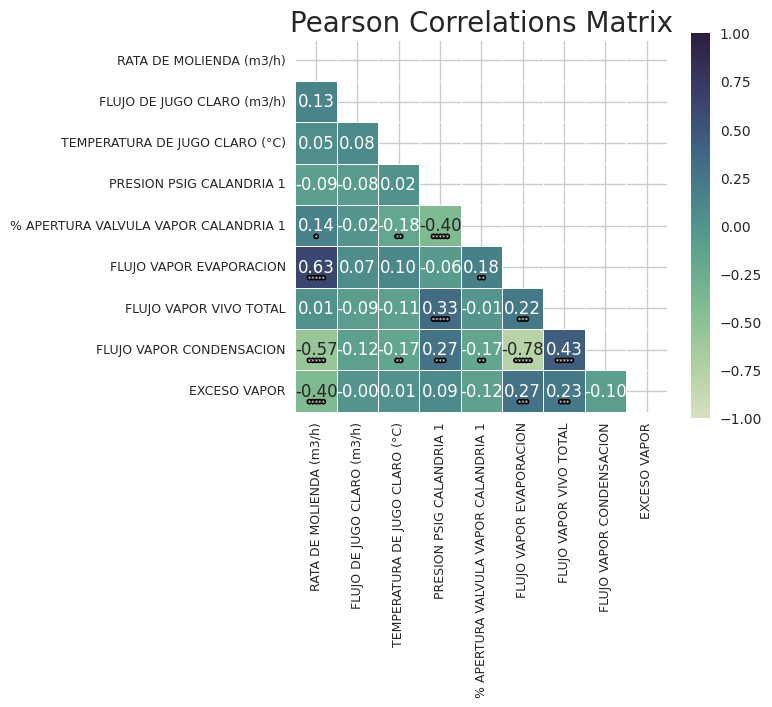

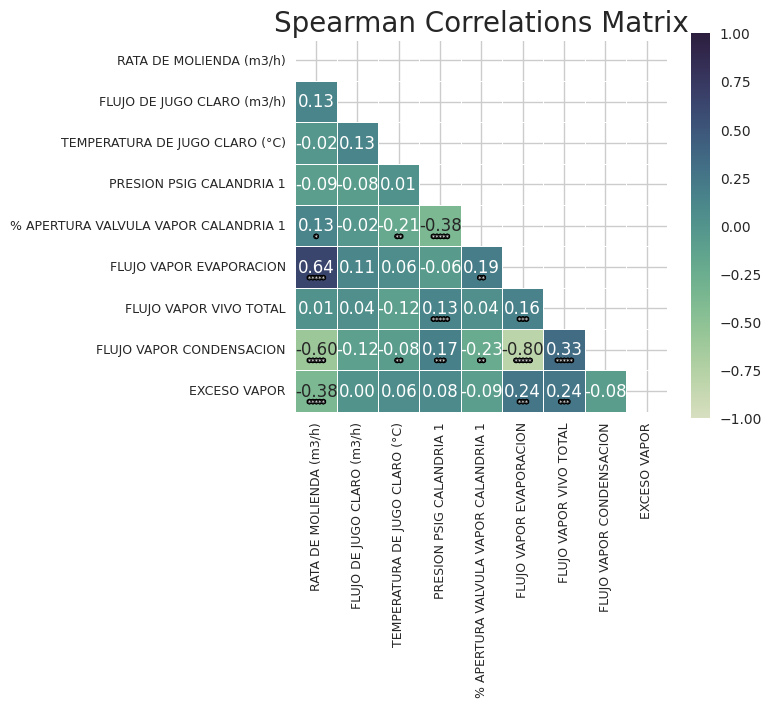

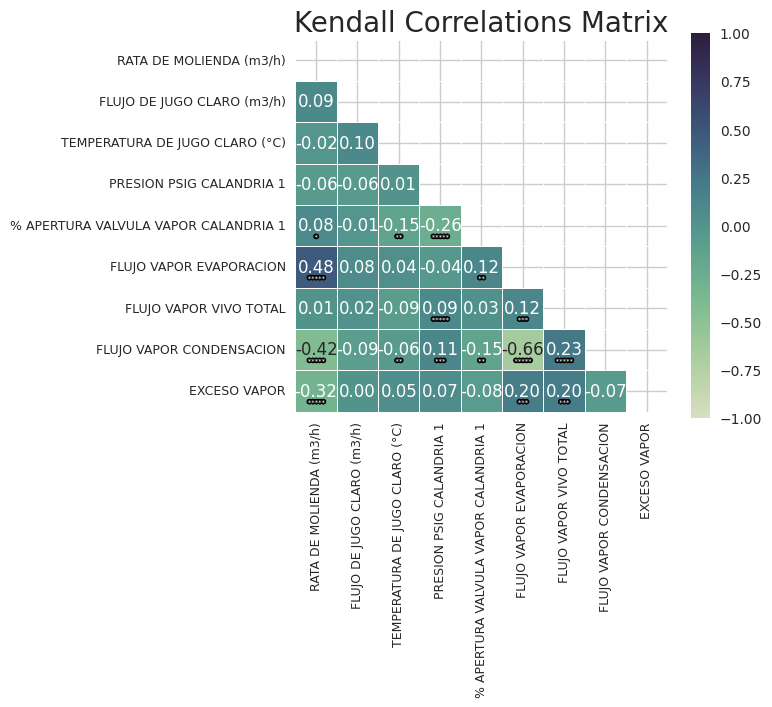

In [21]:
correlation_methods = ['pearson','spearman','kendall']
plot_correlations(df1[atributos],correlation_methods)

En esta segunda fase de interpretación de la información, gracias a las graficas podemos concluir que:
* El % de apertura de valvula de control tiene una relación inversamente proporcional a la presión en la calandria. Esta hipotesis se oberva bajo los 3 métodos teniendo en cuenta el valor alpha que garantiza que esta relación no es producto del azar a pesar que su magnitud no tan significantemente alta.
* Se confirma que las variables de flujo de vapor a evaporacion y condensacion tienen una fuerte relación con la rata de molienda.

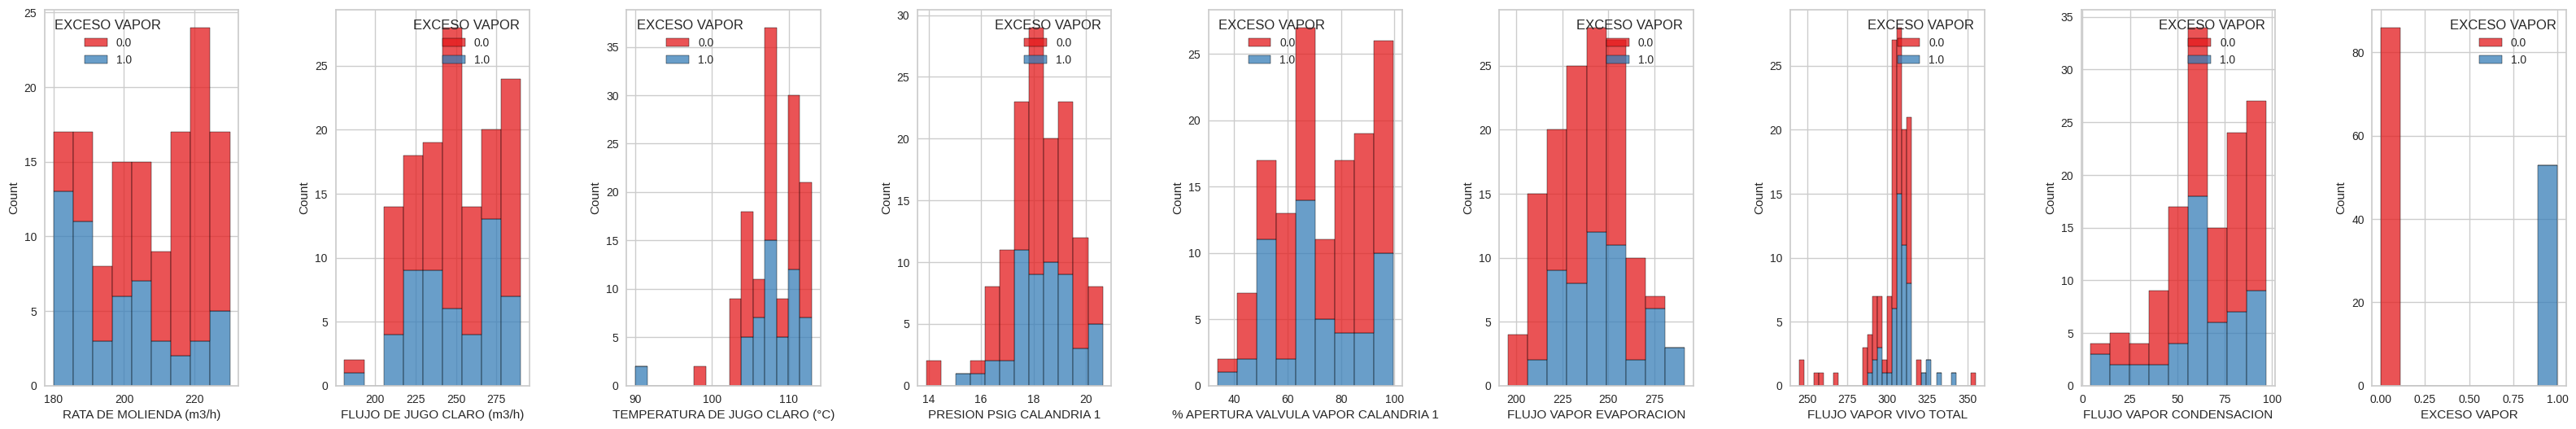

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=9, figsize=(40, 6), squeeze=False, gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

for i, feature in enumerate(atributos):
    row = i // 31  # Calcular el índice de la fila
    col = i % 31   # Calcular el índice de la columna
    sns.histplot(x=df1[feature], hue=df1['EXCESO VAPOR'], multiple="stack", palette="Set1", ax=axes[row, col])
    #axes[row, col].set_title(feature)  # Añadir títulos a las subtramas
    plt.savefig("complete_histogram.png")

plt.show()

En este punto cabe hacer la aclaración nuevamente de que la variable 'EXCESO VAPOR' esta en dos estados asi: 0 == NO y 1 == SI.
* Se puede evidenciar que existe un desbalance en el DATA SET para la variable objetivo, donde el valor "0 == NO" tiene mayor presencia en los registros.
* La condición de EXCESO VAPOR se puede notar con mayor presencia en ratas de molienda bajas.

Text(0, 0.5, 'Atributo')

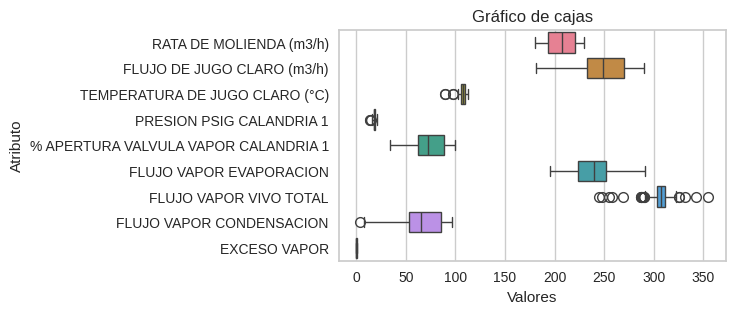

In [23]:
fig, ax = plt.subplots(figsize=(5,3))

# Crea un boxplot con los atributos del eje X verticales
sns.boxplot(data=df1, orient="h", ax=ax)

plt.title('Gráfico de cajas')
plt.xlabel('Valores')
plt.ylabel('Atributo')

De acuerdo con las graficas de cajas, algunas variables presentan datos que podrian considerarse "atipicos" ya que no estan dentro de la caja, sin embargo al revisar lo datos y basados en la teoria de Peter Rein en su libro ingenieria de la caña de azucar y al revisar las fichas tecnicas y manuales de los equipos relacionados con estas variables concluimos que no son atipicos ya que estan dentro de los parametros posibles de los mismos.

Esto nos lleva a pensar que para estos casos especiales donde se presentan datos tal vez "no promedio" se tiene una oportunidad de hacer un analisis de falla o deteccion de fallas en la operacion, ya sea por intervencion humana, falla mecanica o alguna falla externa que esta generando ruido en los datos obtenidos.

Este tipo de analisis sera caso de estudio mas adelante.

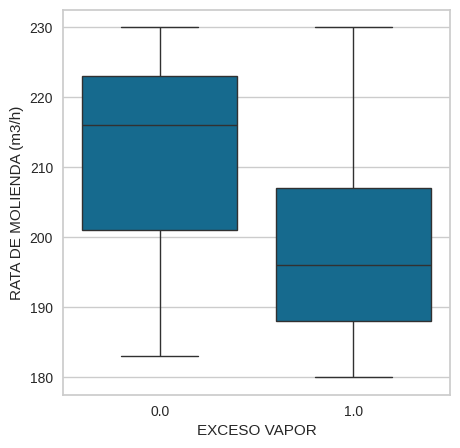

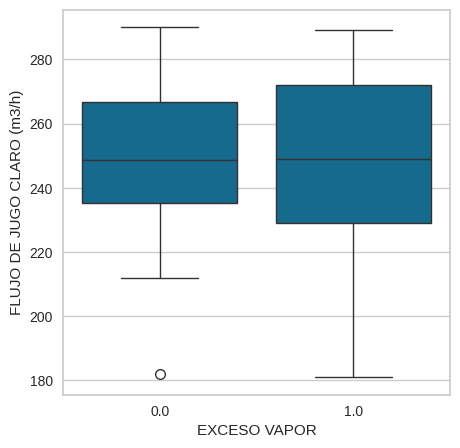

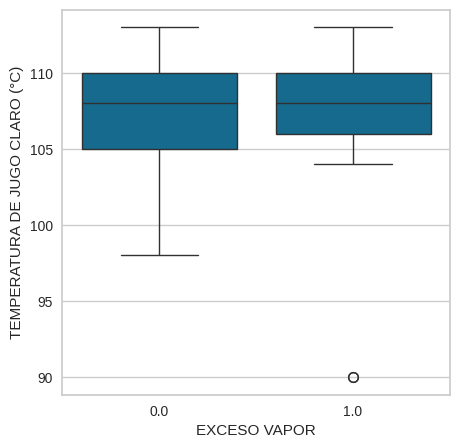

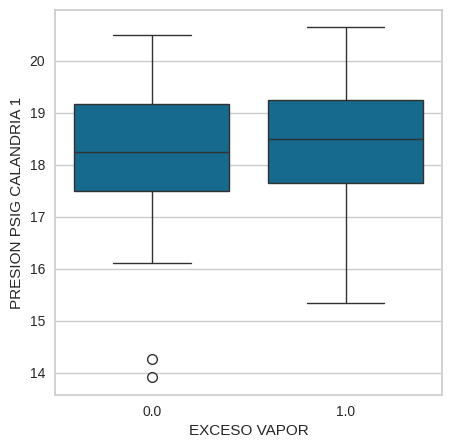

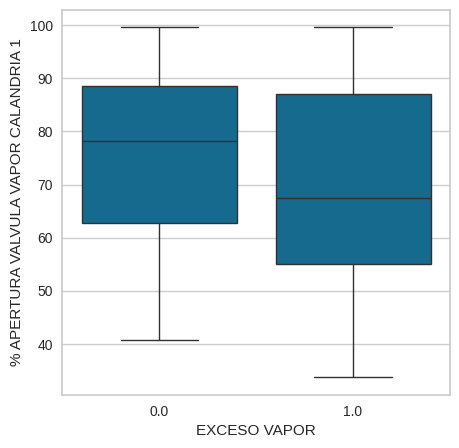

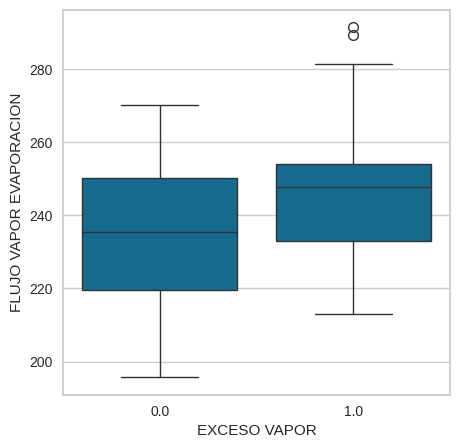

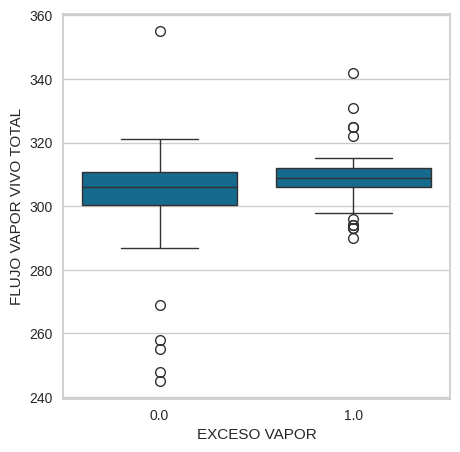

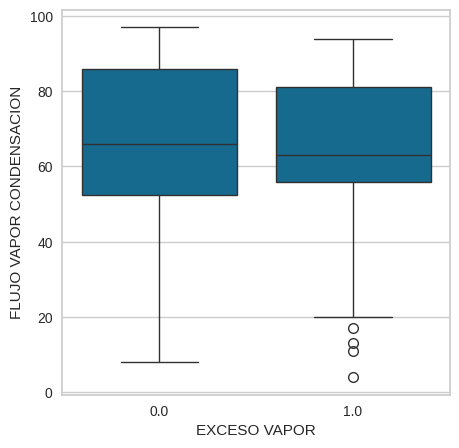

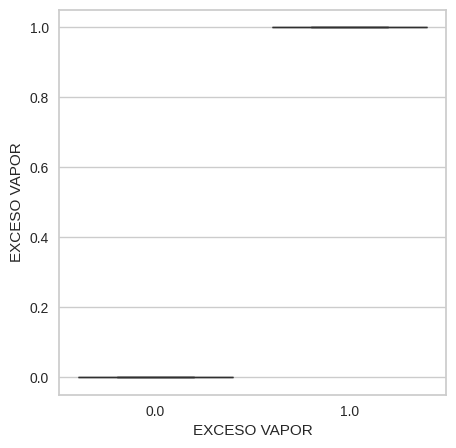

In [24]:
def bivariate_analysis_numerical(df1, var_target, var_numerical):
    for col in var_numerical:
        plt.figure(figsize=(5, 5))
        sns.boxplot(x=var_target,y=col,data=df1)
        plt.show()

bivariate_analysis_numerical(df1,'EXCESO VAPOR',atributos)

Del analisis Bi Variado con cajas podriamos concluir que hay una mayor distribución de casos de EXCESO VAPOR cuanto mas alta es la apertura de la valvula control de vapor.

# Fase 3: Ingeniería de Características
* Análisis de PCA con explicación de varianza.
* Balanceo de Datos con implementación de RANDOM OVER SAMPLING con base en resultado de Varianza explicada.


In [25]:
# Variables
X = df1.drop(["EXCESO VAPOR"], axis=1) # Características
y = df1["EXCESO VAPOR"] # Etiqueta
current_path=pl.Path.cwd()

In [26]:
pca = PCA()
components = pca.fit_transform(X)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# ATRIBUTOS", "y": "Varianza Explicada"}
)
fig.write_html(current_path.joinpath('PCA_explained_variance_cumulative.html'))
fig.show()

In [27]:
pca = PCA()
components = pca.fit_transform(X)

# Create a pandas DataFrame with the explained variance ratio and component number
pca_data = pd.DataFrame({'Component': range(1, pca.n_components_ + 1), 'Explained Variance Ratio': pca.explained_variance_ratio_})

# Create a bar plot using Plotly Express
fig = px.bar(pca_data, x='Component', y='Explained Variance Ratio', title='PCA Explained Variance')

# Customize the plot
fig.update_layout(
    xaxis_title='PCA ATRIBUTOS',
    yaxis_title='Variance %',
    xaxis_tickmode='linear',  # Display all component numbers on the x-axis
    xaxis_tickvals=pca_data['Component'],  # Set the tick values to component numbers
    xaxis_ticktext=pca_data['Component'],  # Set the tick labels to component numbers
)

# Save the plot as an HTML file
fig.write_html(current_path.joinpath('PCA_explained_variance_bar.html'))

# Display the plot
fig.show()

Con el anterior gráfico podemos determinar que el PCA podria aplicarse con minimo con 4 atributos para trabajar con una varianza explicada del 94%, esto nos permitira reducir carga computacional al reducir la cantidad de datos a procesar.

In [28]:
features=['RATA DE MOLIENDA (m3/h)', 'FLUJO DE JUGO CLARO (m3/h)',
       'TEMPERATURA DE JUGO CLARO (°C)', 'PRESION PSIG CALANDRIA 1',
       '% APERTURA VALVULA VAPOR CALANDRIA 1', 'FLUJO VAPOR EVAPORACION',
       'FLUJO VAPOR VIVO TOTAL', 'FLUJO VAPOR CONDENSACION']

In [29]:
n_components=4
pca = PCA(n_components)
components = pca.fit_transform(X)
total_var = pca.explained_variance_ratio_.sum() * 100
loadings = (pca.components_.T * np.sqrt(pca.explained_variance_))* 3


labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
fig = px.scatter(
    components,
    labels=labels,
    x=0, y=1,
    color=y,
    title=f'Varianza Total Explicada del {total_var:.2f}% con las cargas de los atributos'
    )


for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.write_html(current_path.joinpath('PCA_loadings.html'))
fig.show()

Con el analisis de la varianza total explicada con los vectores de carga de los atributos, podemos confirmar que las hipotesis planteadas anteriormente si son correctas.
El PCA nos indica que las variables :
1. FLUJO VAPOR CONDENSACION (KLb/h)
2. FLUJO VAPOR EVAPORACION (KLb/h)
3. RATA DE MOLIENDA (m3/h)
4. % APERTURA VALVULA VAPOR CALANDRIA 1

Tiene una mayor incidencia en el orden que fueron mencionadas.

In [30]:
# Función para aplicar Random Over-Sampling
def oversample(df1, target_variable):
  """
  Aplica Random Over-Sampling a un DataFrame.

  Parámetros:
    df: El DataFrame que se desea balancear.
    target_variable: La variable objetivo con la que se desea balancear el DataFrame.

  Retorno:
    Un DataFrame balanceado con respecto a la variable objetivo.
  """

  # Se divide el DataFrame en la mayoría y la minoría
  majority = df[df[target_variable] == 0]
  minority = df[df[target_variable] == 1]

  # Se aplica Random Over-Sampling a la minoría
  oversampled_minority = resample(minority, replace=True, n_samples=len(majority))

  # Se combinan la mayoría y la minoría sobremuestreada
  balanced_df1 = pd.concat([majority, oversampled_minority])

  return balanced_df1
# Se aplica Random Over-Sampling
balanced_df1 = oversample(df1, "EXCESO VAPOR")

In [31]:
df2=balanced_df1.copy()
print("Tamaño del conjunto de datos #1 (df1):",df.shape)# Imprimir parte de los datos den data_frame
print("Tamaño del conjunto de datos #2 (df2):",df2.shape)# Imprimir parte de los datos den data_frame

Tamaño del conjunto de datos #1 (df1): (139, 9)
Tamaño del conjunto de datos #2 (df2): (172, 9)


Despues de aplicar RANDOM OVER SAMPLING (ROS) se observa la creacion de 33 registros adicionales para balancear el data set original.

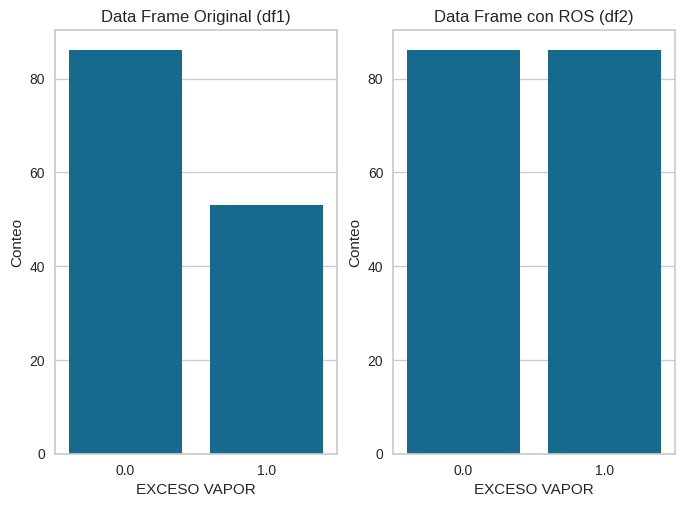

In [32]:
# Contar el número de datos por clase en el data frame original
conteo_original = df1['EXCESO VAPOR'].value_counts()

# Contar el número de datos por clase en el data frame resampled
conteo_resampled = df2['EXCESO VAPOR'].value_counts()

# Crear un gráfico de barras para el data frame original
plt.subplot(121)
sns.barplot(x=conteo_original.index, y=conteo_original)
plt.title("Data Frame Original (df1)")
plt.xlabel("EXCESO VAPOR")
plt.ylabel("Conteo")

# Crear un gráfico de barras para el data frame resampled
plt.subplot(122)
sns.barplot(x=conteo_resampled.index, y=conteo_resampled)
plt.title("Data Frame con ROS (df2)")
plt.xlabel("EXCESO VAPOR")
plt.ylabel("Conteo")

# Mostrar el gráfico
plt.show()

Finalmente logramos obtener un nuevo Data Frame = df2 con un tamaño de 172 registros con 9 atributos [172 , 9] y notamos que los 33 registros adicionales fueron generados para la condicion de EXCESO VAPOR == 1 : "SI".
Asi concluimos que el df2 esta balanceado con 50% datos == 1 y 50% datos == 0.

In [33]:
df2.head()

,RATA DE MOLIENDA (m3/h),FLUJO DE JUGO CLARO (m3/h),TEMPERATURA DE JUGO CLARO (°C),PRESION PSIG CALANDRIA 1,% APERTURA VALVULA VAPOR CALANDRIA 1,FLUJO VAPOR EVAPORACION,FLUJO VAPOR VIVO TOTAL,FLUJO VAPOR CONDENSACION,EXCESO VAPOR
0,220.0,218.0,108.0,16.54,94.47,231.74,320.0,88.0,0.0
3,202.0,227.0,105.0,18.51,67.29,217.76,310.0,92.0,0.0
6,223.0,228.0,112.0,18.61,82.75,252.99,313.0,60.0,0.0
10,213.0,283.0,108.0,18.12,62.77,241.87,308.0,66.0,0.0
13,208.0,238.0,111.0,18.62,76.56,234.21,296.0,62.0,0.0


# Fase 4: Preprocesamiento de datos
* Estandarización y escalado de Data frame para lograr mejores resultados en el modelo aplicado.
1. Escalamiento bajo: StandarScaler

# NOTA DE LA FASE 4:
**LA FASE 4 SE ESTA INDICANDO CON EL OBJETIVO DE REALIZAR LA APLICACION DEL METODO EN CASO DE QUERER IMPLEMENTAR UN MODELO EN ESPECIFICO O YA BIEN DEFINIDO, SIN EMBARGO DEBIDO A QUE SE ESTA IMPLEMENTANDO LA LIBRERIA PyCaret CON EL OBJETIVO DE ENCONTRAR EL MEJOR MODELO, IMPLICITAMENTE SE REALIZA EL NORMALIZADO DE LA INFORMACION.**

In [34]:
df3=df2.copy()

In [35]:
variables_numericas= df3.select_dtypes(include=['number']).columns
print(variables_numericas)

Index(['RATA DE MOLIENDA (m3/h)', 'FLUJO DE JUGO CLARO (m3/h)',
       'TEMPERATURA DE JUGO CLARO (°C)', 'PRESION PSIG CALANDRIA 1',
       '% APERTURA VALVULA VAPOR CALANDRIA 1', 'FLUJO VAPOR EVAPORACION',
       'FLUJO VAPOR VIVO TOTAL', 'FLUJO VAPOR CONDENSACION', 'EXCESO VAPOR'],
      dtype='object')


In [36]:
variables= variables_numericas.drop(['EXCESO VAPOR']) # Características
print(variables)

Index(['RATA DE MOLIENDA (m3/h)', 'FLUJO DE JUGO CLARO (m3/h)',
       'TEMPERATURA DE JUGO CLARO (°C)', 'PRESION PSIG CALANDRIA 1',
       '% APERTURA VALVULA VAPOR CALANDRIA 1', 'FLUJO VAPOR EVAPORACION',
       'FLUJO VAPOR VIVO TOTAL', 'FLUJO VAPOR CONDENSACION'],
      dtype='object')


In [38]:
scalerSS = StandardScaler()
df3[variables] = scalerSS.fit_transform(df3[variables])

In [39]:
df3.head()

,RATA DE MOLIENDA (m3/h),FLUJO DE JUGO CLARO (m3/h),TEMPERATURA DE JUGO CLARO (°C),PRESION PSIG CALANDRIA 1,% APERTURA VALVULA VAPOR CALANDRIA 1,FLUJO VAPOR EVAPORACION,FLUJO VAPOR VIVO TOTAL,FLUJO VAPOR CONDENSACION,EXCESO VAPOR
0,0.859736,-1.250381,0.087530,-1.590942,1.305241,-0.492422,1.164806,1.101825,0.0
3,-0.269557,-0.880217,-0.718996,0.155445,-0.276128,-1.157929,0.381590,1.278693,0.0
6,1.047952,-0.839087,1.162898,0.244094,0.623356,0.519169,0.616555,-0.136250,0.0
10,0.420567,1.423029,0.087530,-0.190286,-0.539108,-0.010191,0.224947,0.129052,0.0
13,0.106874,-0.427793,0.894056,0.252959,0.263213,-0.374839,-0.714912,-0.047816,0.0


# Fase 5: Evaluación del modelo
* Se realizara la implementacion de la libreria PyCaret para determinar el mejor modelo con el df2.
* Se generara un grafico que permite visualizar diferentes metricas y graficas. * Adicional se generan las graficas:


1.   Métricas de rendimiento
2.   Matriz de confusión
3. Curva ROC
4. Pipeline



**¿Es adecuado usar el modulo *Classification* de PyCaret?**

Tomado de: https://pycaret.gitbook.io/docs/get-started/quickstart#classification

"🚀 Classification
PyCaret’s Classification Module is a supervised machine learning module that is used for classifying elements into groups.

The goal is to predict the categorical class labels which are discrete and unordered. Some common use cases include predicting customer default (Yes or No), predicting customer churn (customer will leave or stay), the disease found (positive or negative).

This module can be used for binary or multiclass problems."

**Concluimos:** Que el modulo de PyCaret es adecuado para la clasificacion dela varible binaria "EXCESO VAPOR", adicional a que esta libreria nos brindara las diferentes metricas requeridas.

In [49]:
df2 = df2.reset_index(drop=True)  # Eliminamos la columna de índice anterior y reiniciamos

exp = ClassificationExperiment()

exp.setup(data=df2,
        target = 'EXCESO VAPOR',
        session_id = 123,
        ignore_features=['FLUJO DE JUGO CLARO (m3/h)','TEMPERATURA DE JUGO CLARO (°C)', 'PRESION PSIG CALANDRIA 1',
                         'FLUJO VAPOR VIVO TOTAL'],
       ) # Decidimos ignorar la anterior informacion basados en el resultado obtenido del PCA y asi facilitar la carga computacional garantizando la varianza explicada del 94%

,Description,Value
0,Session id,123
1,Target,EXCESO VAPOR
2,Target type,Binary
3,Original data shape,"(172, 9)"
4,Transformed data shape,"(172, 5)"
5,Transformed train set shape,"(120, 5)"
6,Transformed test set shape,"(52, 5)"
7,Ignore features,4
8,Numeric features,4
9,Preprocess,True


In [53]:
# OOP API
best = exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9833,1.0000,0.9833,0.9857,0.9832,0.9667,0.9690,0.1280
dt,Decision Tree Classifier,0.9583,0.9583,0.9667,0.9548,0.9589,0.9167,0.9202,0.0380
ada,Ada Boost Classifier,0.9583,0.9917,0.9667,0.9607,0.9598,0.9167,0.9243,0.1230
lr,Logistic Regression,0.9500,0.9806,0.9500,0.9571,0.9478,0.9000,0.9088,0.0430
et,Extra Trees Classifier,0.9500,0.9889,0.9500,0.9607,0.9507,0.9000,0.9088,0.1620
ridge,Ridge Classifier,0.9417,0.0000,0.9500,0.9464,0.9412,0.8833,0.8950,0.0740
rf,Random Forest Classifier,0.9417,0.9778,0.9500,0.9464,0.9431,0.8833,0.8933,0.2820
lda,Linear Discriminant Analysis,0.9417,0.9889,0.9500,0.9464,0.9412,0.8833,0.8950,0.0370
qda,Quadratic Discriminant Analysis,0.9250,0.9889,0.9667,0.9012,0.9292,0.8500,0.8600,0.0370
xgboost,Extreme Gradient Boosting,0.9250,0.9806,0.9167,0.9371,0.9206,0.8500,0.8595,0.0800


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [54]:
print(best)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


Se puede concluir entonces que el mejor modelo, con las mejores metricas para realizar esta implementacion es el **"GradientBoostingClassifier"**
En el siguiente apartado se podran recorrer y visualizar la diferentes metricas y curvas relacionadas con el rendimiento del modelo de forma dinamica.

In [61]:
exp.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

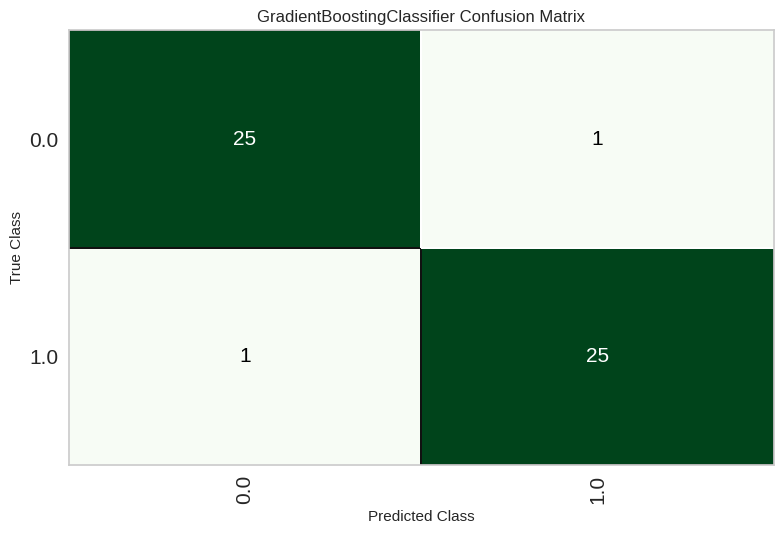

In [56]:
# OOP API
exp.plot_model(best, plot = 'confusion_matrix')

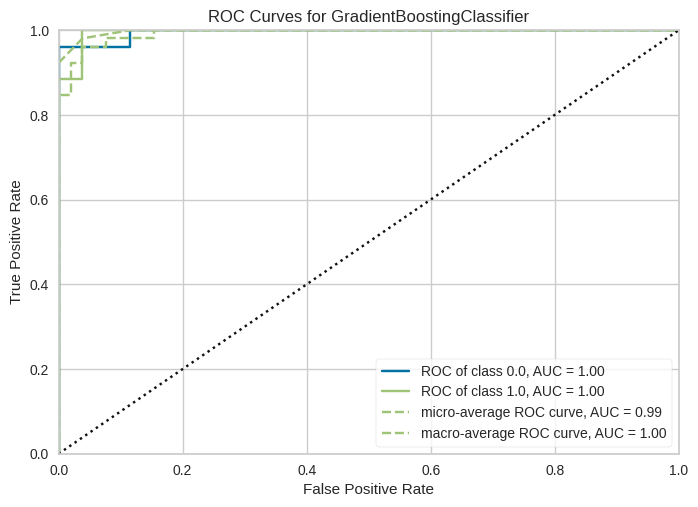

In [57]:
# OOP API
exp.plot_model(best, plot = 'auc')

# Modelo a implementar como *PipeLine*


In [59]:
# OOP API
exp.save_model(best, 'my_best_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['RATA DE MOLIENDA (m3/h)',
                                              '% APERTURA VALVULA VAPOR '
                                              'CALANDRIA 1',
                                              'FLUJO VAPOR EVAPORACION',
                                              'FLUJO VAPOR CONDENSACION'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))...
                   

In [60]:
# OOP API
loaded_model = exp.load_model('my_best_pipeline')
print(loaded_model)

Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['RATA DE MOLIENDA (m3/h)',
                                             '% APERTURA VALVULA VAPOR '
                                             'CALANDRIA 1',
                                             'FLUJO VAPOR EVAPORACION',
                                             'FLUJO VAPOR CONDENSACION'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                   

# Conclusiones finales

Con el avance de la implementacion durante las diferentes fases realizaremos unas conclusiones de cada una de ellas:

1. Fase #1: Realizar el analisis basico del dataset permite conocer inicialmente las condiciones de la informacion. Inicialmente consideré que los datos obtenidos de campo ya contenian del formato adecuado, a lo cual se tuvo que invertir un tiempo considerable para realizar la ingenieria de datos respectiva y obtener un df1 limpio y ajustado a lo que se esperaba.

2. Fase #2: realizando el EDA del df1 determinamos la relacion lineal de algunas de las variables a simple vista, esto nos permitio avanzar con unas hipotesis de correlación entre las variables: rata molienda, vapor a evaporacion y vapor a cogeneracion. Finalmente con las correlaciones de Pearson, Sperman y Kendall encontramos 2 variables mas que hacian parte importante de forma independiente como presion de vapor y % de valvula de control.
3. Fase #3: Ejecutando el PCA y analizando su varianza explicada pudimos corroborar que las 5 variables que anteriormente mencionamos podian explicar el 99% de la relacion de la informacion y que con 4 de 9 variables podriamos explicar el fenomeno de EXCESO VAPOR que se considera la variable objetivo.
4. Fase #4: se realizo este paso de forma indicada, sin embargo no nos aporto en nada al modelo debido a que despues decidimos implementar la libreria PyCaret y esta implícitamente considera el proceso de normalizado de la información. Claramente en este caso este paso es totalmente omitible.
5. Fase #5: Con la implementación de PyCaret obtenemos resultamos concretos sobre el mejor modelo a implementar para esta aplicacion en particular. Podemos afirmar que el resultado es concreto ya que han sido evaluados 15 modelos de aprendizaje automatico y contundente ya que existe una diferencia de precision entre el modelo en segundo lugar *Decision Tree Classifier* con el 95,83% y el modelo en primer lugar *Gradient Boosting Classifier* con el 98,33%.



---


# **PipeLine:**
finalmente obtenemos un modelo del *PipeLine* listo para ser ejecutado directamente.

¿Que significa esto?

Que despues de realizar todo trabajo anteriormente expuesto en 5 fases, simplemente ejecutando:

     loaded_model = exp.load_model('my_best_pipeline')
     
Pordiamos comenzar a evaluar nueva información para ser clasificada como una condición de EXCESO DE VAPOR: SI ó NO.

¿Que nos permite el PipeLine?

Encapsular todo el preprocesamiento que requiere la informacion "cruda" y obtener un resultado preciso de si aplica o no para la condicion objetivo a traves de un modelo como Gradient Boosting Classifier que nos garantiza un 98,33% de precision en su clasificación.







---


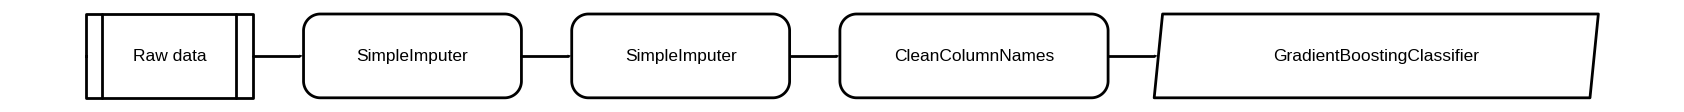


---FIN---